# Lab 3

### Ashwin Rajgopal

Import `libsvm` python library as required. `random` and `numpy` used for k-fold cross validation.
Pyplot is used for graphing results.

In [1]:
from libsvm import svmutil
import random
import numpy as np
import matplotlib.pyplot as plt

Generate a list of powers of 2 starting at 2^-4 to serve as values for the hyperparameters C and alpha.

In [2]:
start_val = 1 / (2 ** 4)
params = [start_val]
while params[-1] < 2 ** 8:
    params.append(params[-1] * 2)

Read ncRNA train and test data into global variables to use as function inputs later.

In [3]:
trainY, trainX = svmutil.svm_read_problem('data/ncRNA_s.train.txt')
testY, testX = svmutil.svm_read_problem('data/ncRNA_s.test.txt')

This next function trains and tests a linear SVM using C as specified from the function input. Runs in quiet mode.
The function will return the accuracy of the trained linear SVM on the supplied test data.

In [4]:
def train_test_linear(train_x, train_y, test_x, test_y, c):
    model = svmutil.svm_train(train_y, train_x, f'-c {c} -q')
    _, acc, _ = svmutil.svm_predict(test_y, test_x, model, '-b 0 -q')
    return acc[0]

This function runs SVM using the RBF function and accepts a parameter for C and alpha to use in the training.
The function will return the accuracy of the trained SVM on the supplied test data.

In [5]:
def train_test_rbf(train_x, train_y, test_x, test_y, c, g):
    model = svmutil.svm_train(train_y, train_x, f'-c {c} -t 2 -g {g} -q')
    _, acc, _ = svmutil.svm_predict(test_y, test_x, model, '-b 0 -q')
    return acc[0]

This function runs cross validation on RBF SVM. For each combination of supplied C values and alpha values,
the function will extract a random sampling of the training data supplied to the function.
Then, the function will train a new RBF SVM k times, k being the number of cross validations.
For each k, the function will extract a subset from the random sample for test data, and use the rest as train data.
When this is done k times, the average of the accuracy percentages is taken and stored in the accuracy matrix.
After all combinations of C and alpha are run, the function takes the argmax on the 2d array which will represent
the indexes in the list of C and alphas that correspond to the optimal C - alpha pair.

In [6]:
def k_fold_best_hp(x, y, cs, gs, k_fold):
    accs = np.zeros((len(cs), len(gs)))
    for i, c in enumerate(cs):
        for j, g in enumerate(gs):
            data = random.sample(list(zip(x, y)), len(x) // 2)
            random.shuffle(data)
            set_accuracies = []
            for k in range(k_fold):
                subset_size = len(data) // 5
                start = k * subset_size
                end = start + subset_size
                test_x, test_y = zip(*data[start:end])
                train_data = data[:start] + data[end:]
                train_x, train_y = zip(*train_data)
                acc = train_test_rbf(train_x, train_y, test_x, test_y, c, g)
                set_accuracies.append(acc)
            accs[i, j] = sum(set_accuracies) / k_fold
    return np.unravel_index(accs.argmax(), accs.shape)

## Results

Run the above functions to get the results of linear SVM and RBF SVM with 5-fold cross validation.

### Linear SVM

Run the linear SVM function on every value of C, and plot the results.

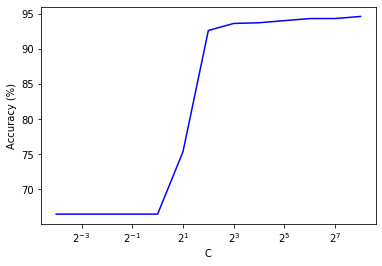

In [7]:
accuracies = []
for C in params:
    accuracies.append(train_test_linear(trainX, trainY, testX, testY, C))
fig = plt.figure()
ax = plt.axes()
ax.plot(params, accuracies, '-b')
plt.xlabel('C')
plt.ylabel('Accuracy (%)')
ax.set_xscale('log', base=2)

The accuracy of linear SVM for this dataset significantly improves when C > 1.
This shows that the shows there is significant noise in the data, and that C needs to be increased
to allow extra slack to the linear SVM.

Now run the RBF SVM, and get the classification accuracy for the optimal pair of C and alpha.

In [8]:
opt = k_fold_best_hp(trainX, trainY, params, params, 5)
c_val = params[opt[0]]
g_val = params[opt[1]]
print(f'The best performing pair of C and alpha is C = {c_val} and alpha = {g_val}.')
accuracy = train_test_rbf(trainX, trainY, testX, testY, c_val, g_val)
print(f'The accuracy for C = {c_val} and alpha = {g_val} is {accuracy:.2f}%.')

The best performing pair of C and alpha is C = 4.0 and alpha = 0.5.
The accuracy for C = 4.0 and alpha = 0.5 is 93.81%.


The trained RBF SVM gets consistently above 94% in multiple runs of this script. While the linear SVM
performed the best at the highest possible value of C, the RBF kernel performs the best generally with
a smaller value of C and alpha. Since the RBF kernel introduces non-linearity into the decision boundary,
SVM no longer needs the maximum value of C and can focus more on maximizing the margin of separation
than minimizing classification error.